This notebook is dedicated to the exploration of the diverse datasets used to assess the performance of the proposed deep models.

In [3]:
# ! pip install pytorch_lightning
import h5py
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import dlib
import os
from PIL import Image
from pytorch_lightning import Trainer

     |████████████████████████████████| 143kB 57.0MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=acac0b08cd38ae281e4e4f89a4c427a68816992069825bd10abcbdc755fd6051
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=789e89718bf658073559a1c32c7e1a43ed015f26f66c5f57e69da629bcc6c0ae
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=b10983402b81de8daf6c0c16e10c090207279b922f28bb1bc914724224c1654c
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built future PyYAML idna-ssl
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled futur

### Utils to preprocess the images:

In [2]:
detector = dlib.get_frontal_face_detector()

def detect_face(img):
    detected = detector(img, 1)    
    return detected[0] if len(detected)==1 else None

def center_crop_face(img,face):
    left,right,bottom,top=face.left(),face.right(),face.bottom(),face.top()
    left=max(left,0)
    right=min(right,img.shape[1])
    top=max(top,0)
    bottom=min(bottom,img.shape[0])

    width = right - left
    height = bottom - top
    tol = 15
    up_down = 5
    diff = height-width

    if diff > 0:
            tmp = img[(top-tol-up_down):(bottom+tol-up_down),
                        (left-tol-diff//2):(right+tol+diff//2), :]
    else:
            tmp = img[(top-tol-diff//2-up_down):(bottom+tol+diff//2-up_down),
                        (left-tol):(right+tol),:]
    return tmp

def resize_face(face,size=(152,152)):
    return  np.array(Image.fromarray(np.uint8(face)).resize(size, Image.ANTIALIAS))

def prepare_dataset(imgs,ages):
    dataset=[]
    for i in range(len(imgs)):
        img=imgs[i]
        try:
            # Detect one face on each image.
            face=detect_face(img)
            if face is None:
                print('face not detected:',i)
                continue

            # Center and crop the image
            face=center_crop_face(img,face)

            # resize the image
            face=resize_face(face)


            dataset.append((face,ages[i]))
        except Exception:
            print('error at:',i)
    return dataset

## CORAL & dataloader

In [24]:
from pytorch_lightning.core.lightning import LightningModule
import torch
from torch import nn

from torchvision.models import resnet34 as resnet

# This is a Linear layer having same weights for each input and different biases for each output unit.
class LinearShared(nn.Module):

    def __init__(self, in_units, out_units):
        super().__init__()

        self.w = nn.Parameter(torch.rand(in_units, 1,requires_grad=True))
        self.b = nn.Parameter(2 * torch.randn(1, out_units,requires_grad=True))

    def forward(self, x):
        x = x @ self.w
        return self.b + x

# Resnet-34 + 1 FC + 1 FC output with sigmoid activation.
class Coral(LightningModule):

    def __init__(self, weights, resnet_units, fc_units, out_units):
        super().__init__()

        assert weights.size() == (1, out_units)

        self.weights = weights
        self.resnet = resnet(pretrained=True, progress=True)
        self.fc = nn.Linear(resnet_units, fc_units)
        self.out = LinearShared(fc_units, out_units)
        self.act=nn.Sigmoid()
        self.cost = nn.BCELoss(reduction='mean')

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        x = self.out(x)
        
        return self.act(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=1e-5)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return self.cost(y_hat, y)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return self.cost(y_hat, y)

    def validation_epoch_end(self,outs):
        print('Worst case:',max(outs))

In [25]:
from typing import Union, List, Optional

from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split
import torch


class DataLoader2(LightningDataModule):

    def __init__(self, n_classes,batch_size, dataset):
        super(DataLoader2, self).__init__()
        self.n_classes=n_classes
        self.batch_size = batch_size
        self.dataset = dataset

    def setup(self):
        split = 8 * len(self.dataset) // 10
        
        # towrite
        data=[]
        for ex in self.dataset:
            tmp=torch.zeros(self.n_classes)
            for i in range(int(ex[1])):
                tmp[i]=1
            data.append((np.rollaxis(ex[0]/256,2,0).astype(np.float32),tmp))

        self.train, self.val = random_split(data, [split, len(data) - split],
                                            torch.random.manual_seed(10))

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train, batch_size=self.batch_size)

    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.val, batch_size=self.batch_size)

# The CACD dataset
The dataset can be found here [CACD](http://bcsiriuschen.github.io/CARC/).

In [ ]:
# contains images
! tar -xzvf drive/MyDrive/Datasets/CACD2000.tar.gz

In [5]:
# contains metadata
PATH='/content/drive/MyDrive/Datasets/celebrity2000.mat'

def read_data(n=200):
    data=h5py.File(PATH,'r')
    d=data['celebrityImageData']
    files,ages=d['name'],d['age']
    rand=np.random.choice(range(files.shape[1]),size=n,replace=False)
    files= [  "".join([chr(item) for item in data[files[0][t]][:]])  for t in rand]
    ages= [ages[0][t]  for t in rand]
    return files,ages

In [6]:
files,ages=read_data(n=200)

In [7]:
# zip images with labels
imgs=[]
for i in range(len(files)):
    img=cv.imread(f"CACD2000/{files[i]}",cv.IMREAD_UNCHANGED)
    img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)

Now, let's visuallize some sample images.

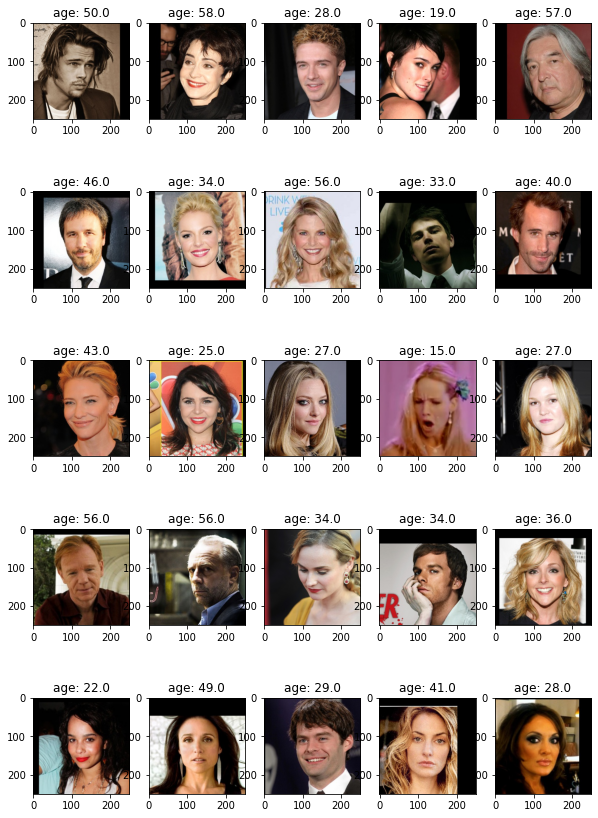

In [8]:
n=5
fig, axs = plt.subplots(n,n,figsize=(2*n,3*n))
imgs_to_plot=np.random.choice(range(len(imgs)),size=n**2,replace=False)
for i in range(n):
    for j in range(n):
        indx=imgs_to_plot[i*n+j]
        axs[i,j].imshow(imgs[indx])
        axs[i,j].set_title(f'age: {ages[indx]}')
plt.show()

Prepare the dataset:

In [9]:
coral_dataset=prepare_dataset(imgs,ages)

face not detected: 8
face not detected: 9
face not detected: 15
face not detected: 118
face not detected: 176


**Testing Coral on modified CACD dataset**

In [14]:
n_classes=100
weights=torch.ones(1,n_classes)
resnets=1000
fc=500

trainer=Trainer(gpus=-1,progress_bar_refresh_rate=20)

data=DataLoader2(n_classes,batch_size=32,dataset=coral_dataset)
data.setup()
model=Coral(weights,resnets,fc,n_classes)
trainer.fit(model,data)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



  | Name   | Type         | Params
----------------------------------------
0 | resnet | ResNet       | 21.8 M
1 | fc     | Linear       | 500 K 
2 | out    | LinearShared | 600   
3 | act    | Sigmoid      | 0     
4 | cost   | BCELoss      | 0     
----------------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
89.195    Total estimated model params size (MB)


Worst case: tensor(61.2188, device='cuda:0')


Worst case: tensor(52.8589, device='cuda:0')


Worst case: tensor(30.2777, device='cuda:0')


Worst case: tensor(24.7935, device='cuda:0')


Worst case: tensor(19.9336, device='cuda:0')


Worst case: tensor(14.6347, device='cuda:0')


Worst case: tensor(12.4936, device='cuda:0')


Worst case: tensor(11.3207, device='cuda:0')


Worst case: tensor(7.5281, device='cuda:0')


Worst case: tensor(6.4729, device='cuda:0')


Worst case: tensor(5.5831, device='cuda:0')


Worst case: tensor(5.0200, device='cuda:0')


Worst case: tensor(4.8395, device='cuda:0')


Worst case: tensor(4.4573, device='cuda:0')


Worst case: tensor(4.4195, device='cuda:0')


Worst case: tensor(4.3823, device='cuda:0')


Worst case: tensor(4.3647, device='cuda:0')


Worst case: tensor(4.3480, device='cuda:0')


Worst case: tensor(4.3522, device='cuda:0')


Worst case: tensor(4.3688, device='cuda:0')


Worst case: tensor(4.3677, device='cuda:0')


Worst case: tensor(4.3013, device='cuda:0')


Worst case: tensor(4.3516, device='cuda:0')


Worst case: tensor(4.3222, device='cuda:0')


Worst case: tensor(4.3593, device='cuda:0')


Worst case: tensor(4.2929, device='cuda:0')


Worst case: tensor(4.3559, device='cuda:0')


Worst case: tensor(4.2631, device='cuda:0')


Worst case: tensor(4.3565, device='cuda:0')


Worst case: tensor(4.2618, device='cuda:0')


Worst case: tensor(4.3528, device='cuda:0')


Worst case: tensor(4.2665, device='cuda:0')


Worst case: tensor(4.2899, device='cuda:0')


Worst case: tensor(4.3011, device='cuda:0')


Worst case: tensor(4.2196, device='cuda:0')


Worst case: tensor(4.3081, device='cuda:0')


Worst case: tensor(4.1785, device='cuda:0')


Worst case: tensor(4.2380, device='cuda:0')


Worst case: tensor(4.2983, device='cuda:0')


Worst case: tensor(4.0397, device='cuda:0')


Worst case: tensor(4.3468, device='cuda:0')


Worst case: tensor(3.9519, device='cuda:0')


Worst case: tensor(4.2955, device='cuda:0')


Worst case: tensor(4.0198, device='cuda:0')


Worst case: tensor(4.1890, device='cuda:0')


Worst case: tensor(4.0463, device='cuda:0')


Worst case: tensor(4.0876, device='cuda:0')


Worst case: tensor(3.9394, device='cuda:0')


Worst case: tensor(4.0426, device='cuda:0')


Worst case: tensor(3.8767, device='cuda:0')


Worst case: tensor(4.0136, device='cuda:0')


Worst case: tensor(3.9339, device='cuda:0')


Worst case: tensor(3.6902, device='cuda:0')


Worst case: tensor(3.9200, device='cuda:0')


Worst case: tensor(3.7262, device='cuda:0')


Worst case: tensor(3.7440, device='cuda:0')


Worst case: tensor(3.7888, device='cuda:0')


Worst case: tensor(3.6219, device='cuda:0')


Worst case: tensor(3.5801, device='cuda:0')


Worst case: tensor(3.5564, device='cuda:0')


Worst case: tensor(3.4866, device='cuda:0')


Worst case: tensor(3.7945, device='cuda:0')


Worst case: tensor(3.4968, device='cuda:0')


Worst case: tensor(3.5325, device='cuda:0')


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

# The AFAD database
The dataset can be found here [AFAD](https://github.com/afad-dataset/tarball).

In [ ]:
%%bash 
git clone https://github.com/afad-dataset/tarball.git
cd /content/tarball/
cat AFAD-Full.tar.xz* > Full.tar.xz
rm  AFAD-Full.tar.xz*
mv Full.tar.xz AFAD-Full.tar.xz
tar -xvf AFAD-Full.tar.xz
wget https://raw.githubusercontent.com/Raschka-research-group/coral-cnn/master/datasets/afad_test.csv
wget https://raw.githubusercontent.com/Raschka-research-group/coral-cnn/master/datasets/afad_train.csv 
wget https://raw.githubusercontent.com/Raschka-research-group/coral-cnn/master/datasets/afad_valid.csv

In [ ]:
PATH='/content/tarball/'
def df(name):
    return pd.read_csv(PATH+name)
names=['afad_train.csv','afad_test.csv','afad_valid.csv']
dfs=[df(t) for t in names]
frame = pd.concat(dfs, ignore_index=True)
frame.path=frame.path.apply(lambda x: '/content/tarball/AFAD-Full/'+str(x))

In [ ]:
frame=frame.sample(frac=1.)
portion=frame.shape[0]//500
imgs=[]
ages=[]
for i in range(portion):
    img=cv.imread(frame.loc[i,'path'],cv.IMREAD_UNCHANGED)
    img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    ages.append(frame.loc[i,'path'].split('/')[-3])

Now, let's visuallize some sample images.

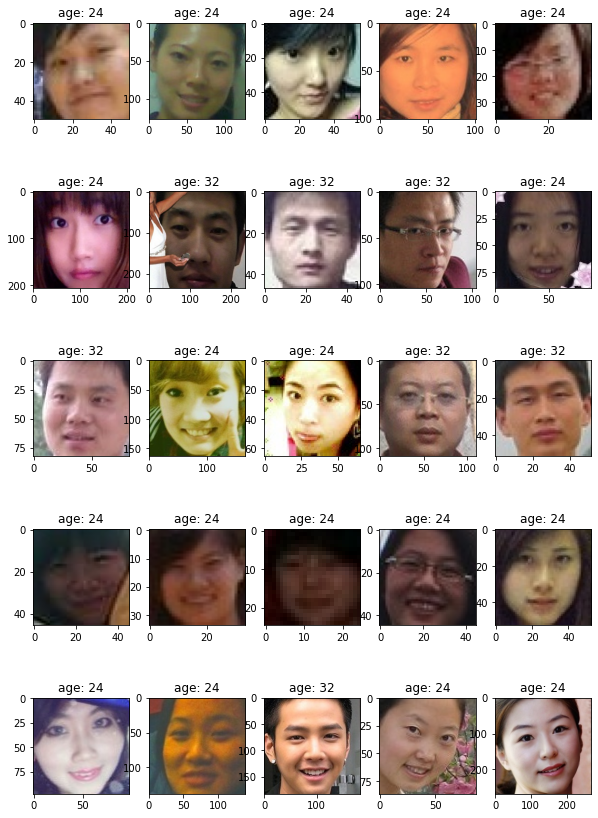

In [ ]:
n=5
fig, axs = plt.subplots(n,n,figsize=(2*n,3*n))
imgs_to_plot=np.random.choice(range(len(imgs)),size=n**2,replace=False)
for i in range(n):
    for j in range(n):
        indx=imgs_to_plot[i*n+j]
        axs[i,j].imshow(imgs[indx])
        axs[i,j].set_title(f'age: {ages[indx]}')
plt.show()

Prepare the dataset:

In [ ]:
afad_dataset=prepare_dataset(imgs,ages)

# The UTKFace dataset
The dataset can be found here [UTKFace](https://susanqq.github.io/UTKFace/).

In [ ]:
%%bash
cd /content/drive/MyDrive/Datasets/
tar -xzvf part1.tar.gz -C /content/
tar -xzvf part2.tar.gz -C /content/
tar -xzvf part3.tar.gz -C /content/
cd /content/
mv part3/* part2/
mv part1/* part2/
mv part2 utk
rm -rf part*

In [16]:
imgs,ages=[],[]
portion=round(0.01*len(os.listdir('utk')))
for f in os.listdir('utk'):
    if len(imgs)==portion:
        break
    img=cv.imread('utk/'+f,cv.IMREAD_UNCHANGED)
    img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    ages.append(f.split('_')[0])

Now, let's visuallize some sample images.

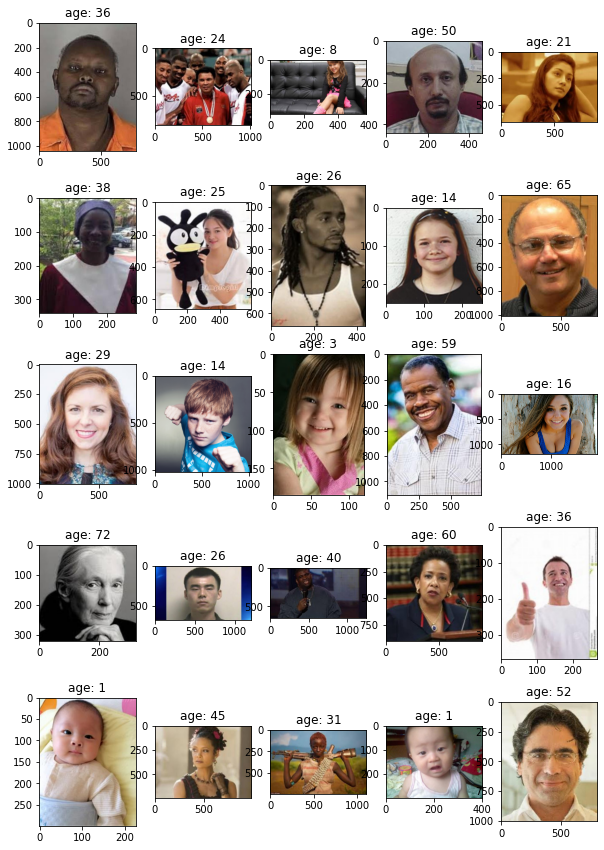

In [17]:
n=5
fig, axs = plt.subplots(n,n,figsize=(2*n,3*n))
imgs_to_plot=np.random.choice(range(len(imgs)),size=n**2,replace=False)
for i in range(n):
    for j in range(n):
        indx=imgs_to_plot[i*n+j]
        axs[i,j].imshow(imgs[indx])
        axs[i,j].set_title(f'age: {ages[indx]}')
plt.show()

Prepare the dataset:

In [18]:
utk_dataset=prepare_dataset(imgs,ages)

face not detected: 26
error at: 48
error at: 49
face not detected: 53
face not detected: 58
face not detected: 64
face not detected: 92
error at: 101
face not detected: 119
error at: 125
error at: 134
face not detected: 144
error at: 149
error at: 162
error at: 190
face not detected: 192
face not detected: 193
face not detected: 200
error at: 221
error at: 238
face not detected: 239


**Training CORAL**

In [23]:
trainer=Trainer(gpus=-1,progress_bar_refresh_rate=20)
data=DataLoader2(n_classes,batch_size=32,dataset=utk_dataset)
data.setup()
model=Coral(weights,resnets,fc,n_classes)
trainer.fit(model,data)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name   | Type         | Params
----------------------------------------
0 | resnet | ResNet       | 21.8 M
1 | fc     | Linear       | 500 K 
2 | out    | LinearShared | 600   
3 | act    | Sigmoid      | 0     
4 | cost   | BCELoss      | 0     
----------------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
89.195    Total estimated model params size (MB)


Worst case: tensor(6.9516, device='cuda:0')


Worst case: tensor(6.6941, device='cuda:0')


Worst case: tensor(6.6185, device='cuda:0')


Worst case: tensor(6.6625, device='cuda:0')


Worst case: tensor(5.9396, device='cuda:0')


Worst case: tensor(5.0890, device='cuda:0')


Worst case: tensor(4.5625, device='cuda:0')


Worst case: tensor(4.0186, device='cuda:0')


Worst case: tensor(3.3209, device='cuda:0')


Worst case: tensor(3.6928, device='cuda:0')


Worst case: tensor(4.0544, device='cuda:0')


Worst case: tensor(4.7907, device='cuda:0')


Worst case: tensor(4.7604, device='cuda:0')


Worst case: tensor(4.8969, device='cuda:0')


Worst case: tensor(4.7509, device='cuda:0')


Worst case: tensor(4.4060, device='cuda:0')


Worst case: tensor(4.1961, device='cuda:0')


Worst case: tensor(4.4129, device='cuda:0')


Worst case: tensor(4.3882, device='cuda:0')


Worst case: tensor(4.4883, device='cuda:0')


Worst case: tensor(4.1404, device='cuda:0')


Worst case: tensor(4.6151, device='cuda:0')


Worst case: tensor(4.3943, device='cuda:0')


Worst case: tensor(4.5593, device='cuda:0')


Worst case: tensor(4.4251, device='cuda:0')


Worst case: tensor(4.5691, device='cuda:0')


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

# The IMDB-WIKI dataset
The dataset can be found here [IMDB-WIKI](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/).

**Omitted**